## Estimate the parameters and subtract our estimate from the data ##

In this notebook, we'll do a crude estimate of the mass of the binary that produced GW170817. We'll make the assumption in this notebook that the component objects have equal mass and aren't spinning.

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir 

Requirement already up-to-date: pycbc in /home/nbuser/anaconda2_501/lib/python2.7/site-packages (1.13.6)
Requirement already up-to-date: lalsuite in /home/nbuser/anaconda2_501/lib/python2.7/site-packages (6.53)
Requirement already up-to-date: ligo-common in /home/nbuser/anaconda2_501/lib/python2.7/site-packages (1.0.3)


### Read in the detector data ###

In [2]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [3]:
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

### Calculate the power spectral density of the data ###

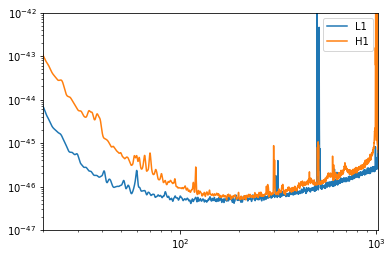

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}
for ifo in ['L1', 'H1']:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step. 
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)

    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], 2 * strain[ifo].sample_rate,
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

### Let's estimate the mass of the system ###

In [5]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

# We will try different component masses and see which gives us the largest 
chirp_mass = numpy.arange(1.1966, 1.1996, .0001)
masses = mass1_from_mchirp_q(chirp_mass, 1)

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []

for m in masses:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
    
    # Matched filter the data and find the peak  
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)

        # The complex SNR at the peak
        snr = snr.time_slice(merger.time - 1, merger.time + 1)
        _, idx = snr.abs_max_loc()
        max_snr[ifo] = snr[idx]
        
        # The time of the peak
        max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
    
    network_snr = (abs(numpy.array(max_snr.values())) ** 2.0).sum() ** 0.5
    snrs.append(max_snr)
    
    # Keep track of only the loudest peak
    if network_snr > nsnr:
        tmax, hmax, mmax, smax = max_time, hp, m, max_snr
        nsnr = network_snr

# See the SNR as a function of the component mass. Notice where this peaks as it gives us
# an estimate of what the parameters of the source system are. Note that masses
# here are in the *detector* frame, so if the source is located far away, it will in
# fact correspond to a lighter system due to cosmological redshift.
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


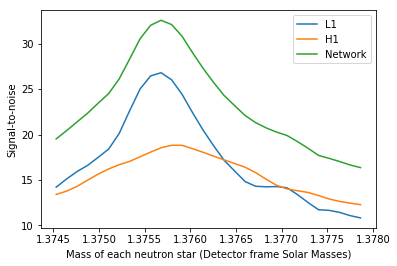

In [6]:
# We can see how the estimate from each IFO agrees
import numpy

network_snrs = [abs(numpy.array(s.values())**2.0).sum()**0.5 for s in snrs]
for ifo in ['L1', 'H1']:
    ind_snrs =  [abs(s[ifo]) for s in snrs]
    pylab.plot(masses, ind_snrs, label=ifo)
    
pylab.plot(masses, network_snrs, label='Network')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass of each neutron star (Detector frame Solar Masses)')
pylab.legend()

### We'll see what's already in the data first ###

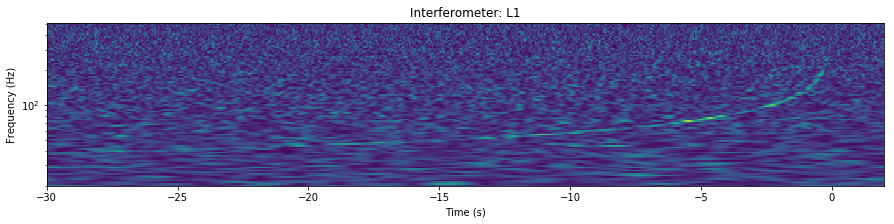

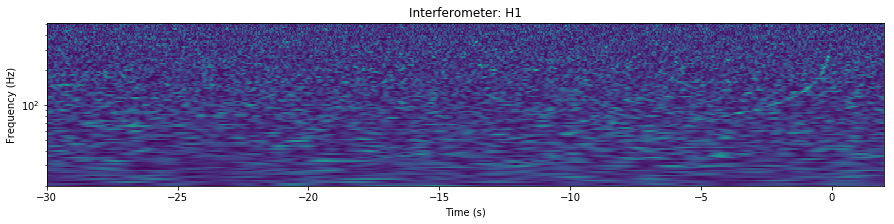

In [7]:
for ifo in ['L1', 'H1']:
    # Whiten the data
    hoft = (stilde[ifo] / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')

### Now we subtract the template we found from the data and see what's left###

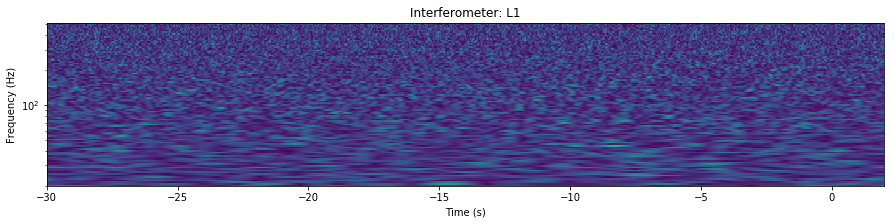

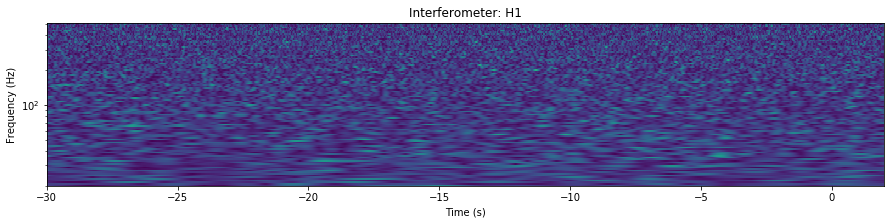

In [8]:
from pycbc.filter import sigma

for ifo in ['L1', 'H1']:
    # Shift the template to the maximum time at this sample rate
    dt =  tmax[ifo] - stilde[ifo].start_time
    inj = hmax.cyclic_time_shift(dt)

    # Scale the template to the SNR and phase we measured above
    inj /= sigma(hmax, psd=psds[ifo], low_frequency_cutoff=20.0) # This scales the template to unit SNR
    inj *= smax[ifo] # This scales the template to the SNR / phase we found

    # Subtract from the data
    stilde2 = stilde[ifo] - inj

    # Whiten the data
    hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')

# Note that a better match to the data can be found if you allow more
# freedom in the possible source parameters than we
# have here.